<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Flemming/AML_IceCores_flemse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [4]:
# save image_size
im_e, lab, feat = sup.__getitem__(147950)
image_size = im_e.shape[0]
image_size

128

In [5]:
lab

6

In [6]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 1000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
29/29 [==============================] - 18s 64ms/step - loss: 0.1091 - val_loss: 0.0519
Epoch 2/200
29/29 [==============================] - 1s 29ms/step - loss: 0.0413 - val_loss: 0.0428
Epoch 3/200
29/29 [==============================] - 1s 29ms/step - loss: 0.0350 - val_loss: 0.0320
Epoch 4/200
29/29 [==============================] - 1s 30ms/step - loss: 0.0285 - val_loss: 0.0282
Epoch 5/200
29/29 [==============================] - 1s 29ms/step - loss: 0.0251 - val_loss: 0.0240
Epoch 6/200
29/29 [==============================] - 1s 30ms/step - loss: 0.0203 - val_loss: 0.0186
Epoch 7/200
29/29 [==============================] - 1s 30ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 8/200
29/29 [==============================] - 1s 30ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 9/200
29/29 [==============================] - 1s 29ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 10/200
29/29 [==============================] - 1s 29ms/step - loss: 0.0121 - val_loss: 0.012

In [8]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [9]:
y_preds = encoder.predict(x_train)

In [10]:
map = umap.UMAP(n_components=2)
y = map.fit_transform(y_preds)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


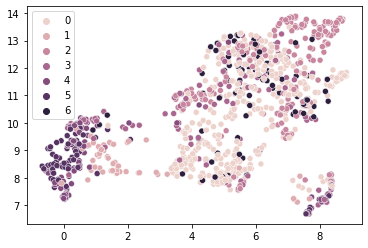

In [11]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

Følgende træner på data hvor der mangler en class, aka label 0,1,2....5, 6
Bagefter prøver vi at lave en prediction på dataen. 

In [12]:
def tree_missingClass(n_class, n_i = 5, nr_ims = 1000, all_classes = False):
  tree = lgb.LGBMClassifier(objective='multiclass')

  for i in range(n_i):
    # create encoder training
    nr_tot_images = len(sup.labels)
    x_train = []
    x_train_lab = []
    x_train_feats = []
    rand_idx = np.arange(0,nr_tot_images)
    rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
    for i in range(nr_ims):
        im, lab, feat = sup.__getitem__(rand_idx[i])
        if lab != n_class or all_classes == True:
          x_train.append(im)
          x_train_lab.append(lab)
          x_train_feats.append(feat)
    x_train = np.array(x_train)
    x_train_lab = np.array(x_train_lab)
    x_train_feats = np.array(x_train_feats)


    y_preds = encoder.predict(x_train)

    x_train_with_encoded = []
    for i in range(len(y_preds)):
        inp = np.append(x_train_feats[i], y_preds[i])
        x_train_with_encoded.append(inp)
    x_train_with_encoded = np.array(x_train_with_encoded)
    
    tree.fit(x_train_with_encoded, x_train_lab)
    return tree

tree = tree_missingClass(0)

In [13]:
# create encoder training
def train(func): #Should have called it predict
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 1000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)

  y_pred = func.predict(x_train_with_encoded)
  return sum(y_pred==x_train_lab)/len(y_pred)



In [14]:
#y_pred = tree.predict(x_train_with_encoded)

In [15]:
#sum(y_pred==x_train_lab)/len(y_pred)

In [16]:
tree_all = train(tree_missingClass(0, all_classes = True))
tree_0 = train(tree_missingClass(0))
tree_1 = train(tree_missingClass(1))
tree_2 = train(tree_missingClass(2))
tree_3 = train(tree_missingClass(3))
tree_4 = train(tree_missingClass(4))
tree_5 = train(tree_missingClass(5))
tree_6 = train(tree_missingClass(6))

print(tree, tree_0, tree_1, tree_2, tree_3, tree_4, tree_5, tree_6)

LGBMClassifier(objective='multiclass') 0.509 0.754 0.636 0.78 0.786 0.751 0.783


Følgende gør det modsatte af før. Her træner vi på alt dataen, men når vi predicter fjerne vi en class aka label.

In [17]:
def predict_with_missing_lass(n_class, func, nr_ims = 1000, all_classes = False):
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      if lab != n_class or all_classes == True:
        x_train.append(im)
        x_train_lab.append(lab)
        x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)

  y_pred = func.predict(x_train_with_encoded)
  return sum(y_pred==x_train_lab)/len(y_pred)



In [18]:
test = tree_missingClass(0, all_classes = True)
pred_all = predict_with_missing_lass(0, test, all_classes = True)
pred_0 = predict_with_missing_lass(0, test)
pred_1 = predict_with_missing_lass(1, test)
pred_2 = predict_with_missing_lass(2, test)
pred_3 = predict_with_missing_lass(3, test)
pred_4 = predict_with_missing_lass(4, test)
pred_5 = predict_with_missing_lass(5, test)
pred_6 = predict_with_missing_lass(6, test)

print(pred_all, pred_0, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6)

0.823 0.7220338983050848 0.8202959830866807 0.7866323907455013 0.8387458006718925 0.8038379530916845 0.8202614379084967 0.8488499452354874


Træner på 6, predicter på de samme 6

In [19]:
remove_both_func = tree_missingClass(0, all_classes = True)
remove_both = predict_with_missing_lass(0, remove_both_func, all_classes = True)

remove_both_func_0 = tree_missingClass(0)
remove_both_0 = predict_with_missing_lass(0, remove_both_func_0)

remove_both_func_1 = tree_missingClass(1)
remove_both_1 = predict_with_missing_lass(1, remove_both_func_1)

remove_both_func_2 = tree_missingClass(2)
remove_both_2 = predict_with_missing_lass(2, remove_both_func_2)

remove_both_func_3 = tree_missingClass(3)
remove_both_3 = predict_with_missing_lass(3, remove_both_func_3)

remove_both_func_4 = tree_missingClass(4)
remove_both_4 = predict_with_missing_lass(4, remove_both_func_4)

remove_both_func_5 = tree_missingClass(5)
remove_both_5 = predict_with_missing_lass(5, remove_both_func_5)

remove_both_func_6 = tree_missingClass(6)
remove_both_6 = predict_with_missing_lass(6, remove_both_func_6)

print(remove_both, remove_both_0, remove_both_1, remove_both_2, remove_both_3, remove_both_4, remove_both_5, remove_both_6)


0.836 0.8079470198675497 0.8197242841993637 0.7913043478260869 0.8592342342342343 0.8660907127429806 0.8353196099674973 0.8591248665955176


Tjek når vi predicter forkert, hvad gør den det så for

In [20]:
tree1 = lgb.LGBMClassifier(objective='multiclass')

for i in range(1):
  # create encoder training
  nr_tot_images = len(sup.labels)
  nr_ims = 1000
  x_train = []
  x_train_lab = []
  x_train_feats = []
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)


  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree1.fit(x_train_with_encoded, x_train_lab)
  

In [21]:
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 1000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

y_preds = encoder.predict(x_train)

x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

y_pred = tree1.predict(x_train_with_encoded)
sum(y_pred==x_train_lab)/len(y_pred)

0.823

In [25]:
list0, list1, list2, list3, list4, list5, list6, errors = [], [], [], [], [], [], [], []
for i in range(len(y_pred)):
  if y_pred[i] != x_train_lab[i]:
    if x_train_lab[i] == 0:
      list0.append(y_pred[i])

    elif x_train_lab[i] == 1:
      list1.append(y_pred[i])
    
    elif x_train_lab[i] == 2:
      list2.append(y_pred[i])
    
    elif x_train_lab[i] == 3:
      list3.append(y_pred[i])
    
    elif x_train_lab[i] == 4:
      list4.append(y_pred[i])
    
    elif x_train_lab[i] == 5:
      list5.append(y_pred[i])
    
    elif x_train_lab[i] == 6:
      list6.append(y_pred[i])
    
    else: 
      errors.append(y_pred[i])

    



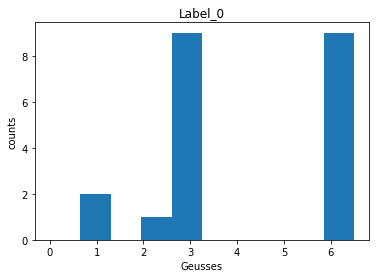

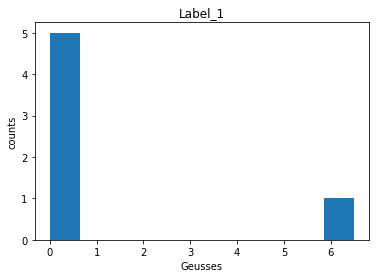

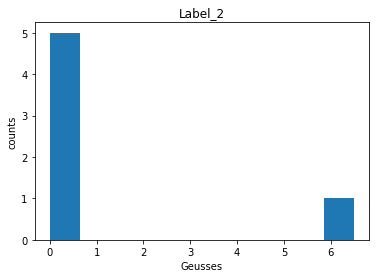

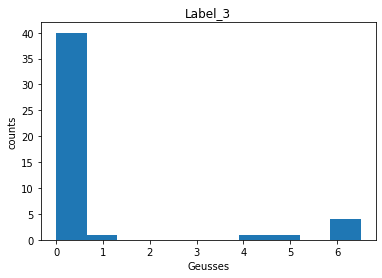

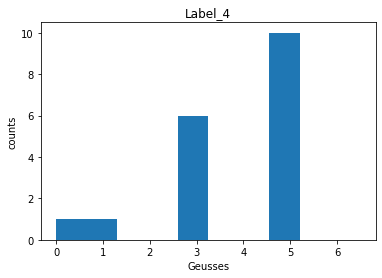

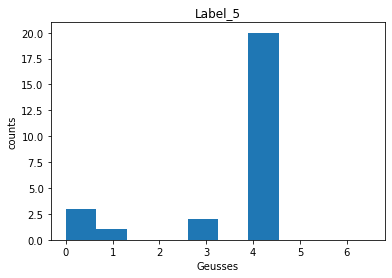

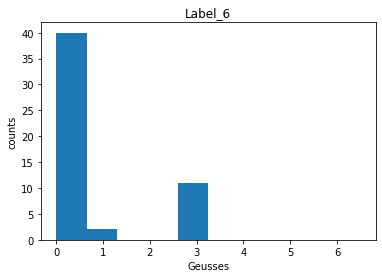

In [46]:
listlist = [list0, list1, list2, list3, list4, list5, list6]
namelist = ["Label_0", "Label_1", "Label_2", "Label_3", "Label_4", "Label_5", "Label_6"]

for i in range(len(listlist)):
  plt.figure(i+1, figsize = (6,4))
  plt.hist(listlist[i], range=[0, 6.5])
  plt.title(namelist[i])
  plt.ylabel("counts")
  plt.xlabel("Geusses")

[4, 4, 0, 4, 3, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4]